# Preparação das Bases

In [3]:
# Importa bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot  as plt
import seaborn as sns

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn import datasets
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import recall_score
from sklearn import tree
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.datasets import make_hastie_10_2

import joblib

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE, ADASYN

In [9]:
# Importa Base de Dados
df_ml = pd.read_csv('C:/Users/CB517RL/OneDrive - EY/Desktop/Projeto final/Grupo2DnA/bases/Prata/clean.csv', sep = ";")
df_ml.head()

,CustomerId,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [18]:
# Substitui variaveis descritivas
df_ml['id_geography'] = df_ml['Geography'].replace({'France': 0, 'Spain': 1, 'Germany': 2})
df_ml['id_gender'] = df_ml['Gender'].replace({'Female': 0, 'Male': 1})

In [19]:
# Exclui colunas que nao serao utilizadas no modelo
df_ml = df_ml.drop(columns=["Geography", "Gender"])

In [20]:
df_ml.head()

,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,id_geography,id_gender
0,15634602,619,42,2,0.00,1,1,1,101348.88,1,0,0
1,15647311,608,41,1,83807.86,1,0,1,112542.58,0,1,0
2,15619304,502,42,8,159660.80,3,1,0,113931.57,1,0,0
3,15701354,699,39,1,0.00,2,0,0,93826.63,0,0,0
4,15737888,850,43,2,125510.82,1,1,1,79084.10,0,1,0


# Analise de correlacao entre as colunas

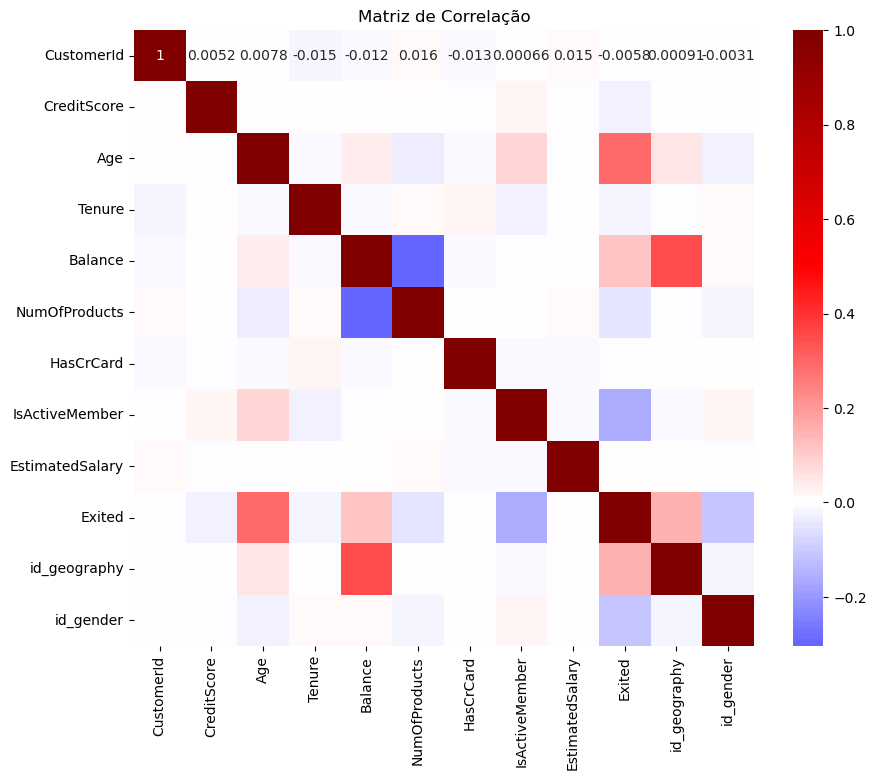

In [21]:
# Análise da correlação entre as colunas
correlation_matrix = df_ml.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='seismic', center=0)
plt.title("Matriz de Correlação")
plt.show()

# Construção dos Modelos

### Definição da variáveis de treino e de teste

In [22]:
# definindo a aleatoriedade para separação das bases de treino e de teste
SEED = 5
np.random.seed(SEED)

In [23]:
# Separa os dados em features e target
x = df_ml[["CreditScore", "Age", "Tenure", "Balance", "NumOfProducts", "HasCrCard", "IsActiveMember", "EstimatedSalary", "id_geography", "id_gender"]] # Features
y = df_ml["Exited"] # Target variable

Base possue grande desproporcionalidade entre os valores de churn positivo e churn negativo, por isso o balanceamento é necessário.

In [24]:
# Usa SMOTE() para balancear a divisao entre número de churn positivos e de negativos
treino_x, treino_y = SMOTE().fit_resample(x, y)

In [25]:
print("Contagem de classes antes do balanceamento:")
print(y.value_counts())
 
print("\nContagem de classes após o balanceamento:")
print(treino_y.value_counts())

Contagem de classes antes do balanceamento:
Exited
0    7934
1    2017
Name: count, dtype: int64

Contagem de classes após o balanceamento:
Exited
1    7934
0    7934
Name: count, dtype: int64


In [26]:
# Divide de variaveis de treino e de teste (features e target)
treino_x, teste_x, treino_y, teste_y = train_test_split(treino_x, 
                                                        treino_y, 
                                                        random_state=SEED, 
                                                        test_size=0.3)

In [27]:
# Escala as duas variáveis
scaler = MinMaxScaler(feature_range=(0, 1))
treino_x = scaler.fit_transform(treino_x)
teste_x = scaler.fit_transform(teste_x)

### SVC

In [28]:
# Modelo SVC
svc = SVC()

In [29]:
# Definindo o espaço de parametros
param_space_svc = {
    'C': Real(1e-6, 1e+6, prior='log-uniform'),
    'kernel': Categorical(['linear', 'poly', 'rbf', 'sigmoid']),
    'degree': Integer(1, 5), # Ignorado para outros kernels que não o 'poly'
    'gamma': Real(1e-6, 1e+1, prior='log-uniform'), # 'scale' e 'auto' também são opções válidas
    'coef0': Real(0, 10),
    'tol': Real(1e-6, 1e-1, prior='log-uniform')
}

# Instancia do BayesSearchCV
bayes_svc = BayesSearchCV(
    estimator=svc,
    search_spaces=param_space_svc,
    n_iter=10,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    random_state=SEED
)

In [30]:
# Modelo com hiperparametros definidos
bayes_svc.fit(treino_x, treino_y)
previsoes_svc = bayes_svc.predict(teste_x)

In [32]:
# Acuracia SVC
acuracia = accuracy_score(teste_y, previsoes_svc) * 100
print("A acurácia foi de: %.2f%%" % acuracia)

A acurácia foi de: 77.97%


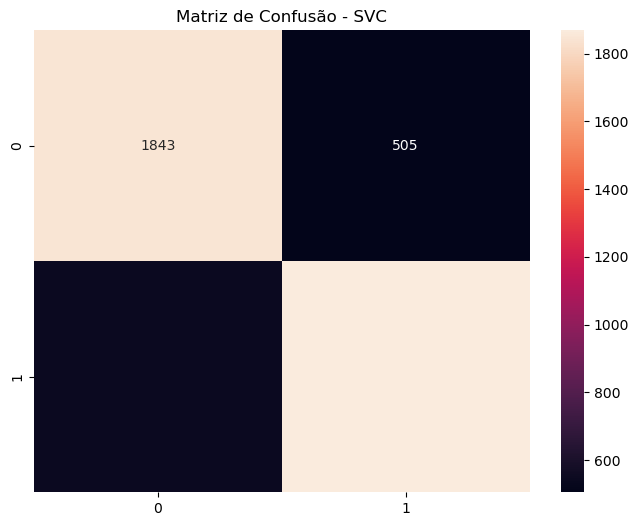

In [33]:
# Matriz de confusao SVC
y_true_svc = teste_y
y_pred_svc = previsoes_svc
matriz_de_confusao_svc = confusion_matrix(y_true_svc, y_pred_svc) 
 
plt.figure(figsize=(8, 6))
 
sns.heatmap(matriz_de_confusao_svc, annot=True, fmt='d')
 
plt.title('Matriz de Confusão - SVC')
plt.show()

In [34]:
matriz_de_confusao_svc

array([[1843,  505],
       [ 544, 1869]], dtype=int64)

In [35]:
# Recall SVC
recall_svc = recall_score(teste_y, previsoes_svc) * 100
print("A taxa de Recall do SVC foi de: %.2f%%" % recall_svc)

A taxa de Recall do SVC foi de: 77.46%


### KNN (K Neighbors Classifier)

In [36]:
# Modelo KNN
knn = KNeighborsClassifier()

In [37]:
# Hiperparâmetros KNN utilizando BayesSearchCV
param_space_knn = {
    'n_neighbors': Integer(1, 30),
    'weights': Categorical(['uniform', 'distance']),
    'metric': Categorical(['euclidean', 'manhattan', 'minkowski']),
    'algorithm': Categorical(['ball_tree', 'kd_tree', 'brute', 'auto'])
}

# Instância do BayesSearchCV
bayes_knn = BayesSearchCV(
    estimator=knn,
    search_spaces=param_space_knn,
    n_iter=50,         
    cv=5,               
    scoring='accuracy', 
    n_jobs=-1,          
    random_state=SEED     
)

In [38]:
# Rodando modelo com hiperparametros definidos
bayes_knn.fit(treino_x, treino_y)
previsoes_knn = bayes_knn.predict(teste_x)

In [39]:
# Acuracia KNN
acuracia_knn = accuracy_score(teste_y, previsoes_knn) * 100
print("A acurácia foi de: %.2f%%" % acuracia_knn)

A acurácia foi de: 81.52%


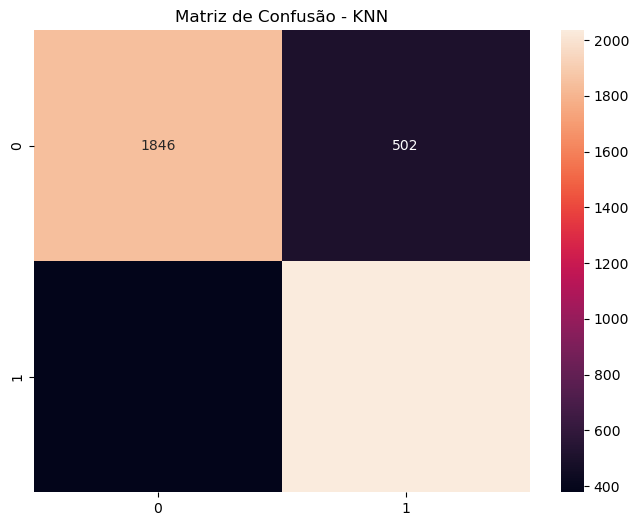

In [40]:
# Matriz de confusao KNN
y_true_knn = teste_y
y_pred_knn = previsoes_knn
matriz_de_confusao_knn = confusion_matrix(y_true_knn, y_pred_knn) 
 
plt.figure(figsize=(8, 6))
 
sns.heatmap(matriz_de_confusao_knn, annot=True, fmt='d')
 
plt.title('Matriz de Confusão - KNN')
plt.show()

In [41]:
matriz_de_confusao_knn

array([[1846,  502],
       [ 378, 2035]], dtype=int64)

In [42]:
# Recall KNN
recall_knn = recall_score(teste_y, previsoes_knn) * 100
print("A taxa de Recall do KNN foi de: %.2f%%" % recall_knn)

A taxa de Recall do KNN foi de: 84.33%


### Arvore de decisao

In [43]:
# Modelo Decision Tree
decisionTree = tree.DecisionTreeClassifier()

In [44]:
param_space_tree = {
    'max_depth': Integer(1, 50),
    'min_samples_split': Integer(2, 100),
    'min_samples_leaf': Integer(1, 50),
    'max_features': Categorical(['auto', 'sqrt', 'log2', None]),
    'max_leaf_nodes': Integer(10, 1000, 'uniform'),
    'criterion': Categorical(['gini', 'entropy'])
}

# Instância do BayesSearchCV
bayes_decisionTree = BayesSearchCV(
    estimator=decisionTree,
    search_spaces=param_space_tree,
    n_iter=50,          # Número de iterações da busca bayesiana
    cv=5,               # Número de folds da validação cruzada
    scoring='accuracy', # Métrica para avaliar o desempenho
    n_jobs=-1,          # Número de processos a serem executados em paralelo
    random_state=SEED    # Semente de aleatoriedade para resultados reprodutíveis
)

In [45]:
bayes_decisionTree.fit(treino_x, treino_y)
previsoes_decisionTree = bayes_decisionTree.predict(teste_x)

In [46]:
# Acuracia Decision Tree
acuracia_tree = accuracy_score(teste_y, previsoes_decisionTree) * 100
print("A acurácia foi de: %.2f%%" % acuracia_tree)

A acurácia foi de: 79.96%


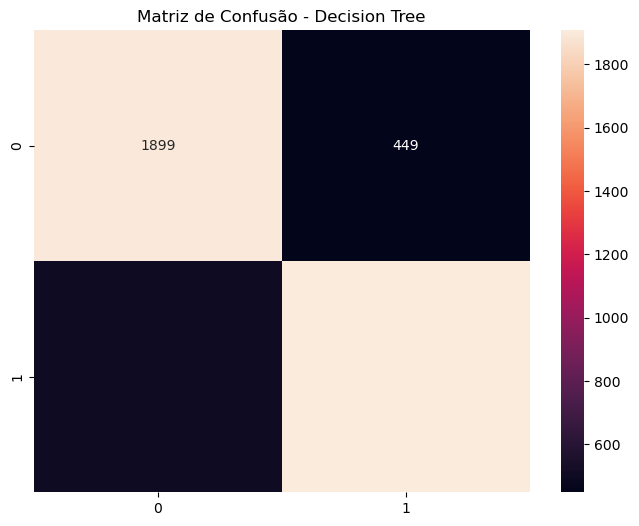

In [47]:
# Matriz de confusao Decision Tree
y_true_tree = teste_y
y_pred_tree = previsoes_decisionTree
matriz_de_confusao_tree = confusion_matrix(y_true_tree, y_pred_tree) 
 
plt.figure(figsize=(8, 6))
 
sns.heatmap(matriz_de_confusao_tree, annot=True, fmt='d')
 
plt.title('Matriz de Confusão - Decision Tree')
plt.show()

In [48]:
matriz_de_confusao_tree

array([[1899,  449],
       [ 505, 1908]], dtype=int64)

In [49]:
# Recall Decision Tree
recall_tree = recall_score(teste_y, previsoes_decisionTree) * 100
print("A taxa de Recall foi de: %.2f%%" % recall_tree)

A taxa de Recall foi de: 79.07%


### XGBOOST

In [50]:
# Modelo XGBOOST
xgboost = XGBClassifier()

In [51]:
# Hiperparâmetros XGBOOST utilizando BayesSearchCV
param_space_xgboost = {
    'n_estimators': Integer(50, 1000),
    'max_depth': Integer(3, 50),
    'learning_rate': Real(0.01, 1.0, 'log-uniform'),
    'subsample': Real(0.5, 1.0),
    'colsample_bytree': Real(0.5, 1.0),
    'min_child_weight': Integer(1, 10),
    'gamma': Real(0, 5),
    'reg_alpha': Real(0, 5),
    'reg_lambda': Real(0, 5)
}

# Instância do BayesSearchCV
bayes_xgboost = BayesSearchCV(
    estimator=xgboost,
    search_spaces=param_space_xgboost,
    n_iter=50,    
    cv=3,         
    scoring='accuracy',  
    n_jobs=-1     
)


In [52]:
# Rodando modelo com hiperparametros definidos
bayes_xgboost.fit(treino_x, treino_y)
previsoes_xgboost = bayes_xgboost.predict(teste_x)

In [53]:
# Acuracia xgboost
acuracia_xgboost = accuracy_score(teste_y, previsoes_xgboost) * 100
print("A acurácia foi de: %.2f%%" % acuracia_xgboost)

A acurácia foi de: 85.80%


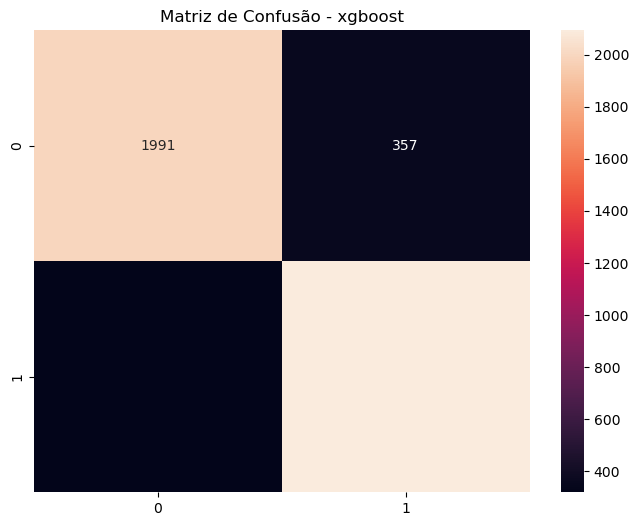

In [54]:
# Matriz de confusao XGBOOST
y_true_xgboost = teste_y
y_pred_xgboost = previsoes_xgboost
matriz_de_confusao_xgboost = confusion_matrix(y_true_xgboost, y_pred_xgboost) 
 
plt.figure(figsize=(8, 6))
 
sns.heatmap(matriz_de_confusao_xgboost, annot=True, fmt='d')
 
plt.title('Matriz de Confusão - xgboost')
plt.show()

In [55]:
matriz_de_confusao_xgboost

array([[1991,  357],
       [ 319, 2094]], dtype=int64)

In [56]:
# Recall XGBOOST
recall_xgboost = recall_score(teste_y, previsoes_xgboost) * 100
print("A taxa de Recall do xgboost foi de: %.2f%%" % recall_xgboost)

A taxa de Recall do xgboost foi de: 86.78%


# Resultados dos Modelos

In [58]:
taxas_acuracia = acuracia, acuracia_knn, acuracia_tree, acuracia_xgboost
taxas_recall = recall_svc, recall_knn, recall_tree, recall_xgboost

In [74]:
data = {
    'Modelo': ['SVC', 'KNN', 'Decision Tree', 'XGBoost'],
    'Acurácia': [acuracia, acuracia_knn, acuracia_tree, acuracia_xgboost],
    'Recall': [recall_svc, recall_knn, recall_tree, recall_xgboost]
}

df_results = pd.DataFrame(data)

In [76]:
df_results.head()

,Modelo,Acurácia,Recall
0,SVC,77.966814,77.455450
1,KNN,81.516488,84.334853
2,Decision Tree,79.962193,79.071695
3,XGBoost,85.801302,86.779942


In [67]:
df_inverse = scaler.inverse_transform(teste_x)

In [60]:
previsoes_xgboost[::,0]

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [ ]:
df_result = pd.DataFrame(df_inverse, columns = ["CreditScore", "Age", "Tenure", "Balance", "NumOfProducts", "HasCrCard", "IsActiveMember", "EstimatedSalary", "id_geography", "id_gender"])
df_result['previsoes'] = previsoes_xgboost[::,1]
df_result.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,id_geography,id_gender,previsoes
0,681.0,29.0,2.0,148143.840000,1.0,1.0,1.0,52021.390000,0.0,0.0,0.071711
1,739.0,37.0,7.0,104960.460000,1.0,0.0,1.0,80883.820000,0.0,1.0,0.007156
2,597.0,35.0,0.0,127510.990000,1.0,1.0,1.0,155356.340000,1.0,1.0,0.013972
3,493.0,44.0,7.0,143684.302485,2.0,1.0,0.0,141391.209481,1.0,0.0,0.748208
4,828.0,42.0,10.0,0.000000,1.0,1.0,1.0,186071.140000,1.0,1.0,0.125778


In [ ]:
churn = df_result[df_result['previsoes'] >= 0.70]
churn.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,id_geography,id_gender,previsoes
3,493.0,44.0,7.0,143684.302485,2.0,1.0,0.0,141391.209481,1.0,0.0,0.748208
8,589.0,42.0,3.0,0.000000,1.0,1.0,0.0,85280.322756,0.0,0.0,0.966777
9,539.0,53.0,3.0,0.000000,1.0,1.0,0.0,49572.912689,0.0,0.0,0.996655
10,633.0,32.0,8.0,108705.687514,1.0,0.0,0.0,179391.055309,1.0,1.0,0.988978
11,650.0,50.0,3.0,126579.260257,1.0,0.0,0.0,17439.864939,2.0,1.0,0.984452


In [ ]:
churn.iloc[0]

CreditScore           493.000000
Age                    44.000000
Tenure                  7.000000
Balance            143684.302485
NumOfProducts           2.000000
HasCrCard               1.000000
IsActiveMember          0.000000
EstimatedSalary    141391.209481
id_geography            1.000000
id_gender               0.000000
previsoes               1.000000
Name: 3, dtype: float64